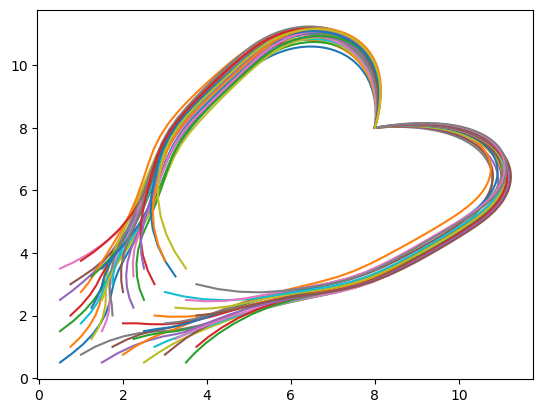

In [1]:
import matplotlib.pyplot as plt

def read_paths(file):
    """
    Reads a file where each 2 lines represent a sequence of 'a' and 'y' coordinates.
    
    Parameters:
    - file: The path to the input text file containing the coordinates.
    
    Returns:
    - A list of lists of tuples, where each tuple represents a point (a, y).
    """
    paths = []
    
    # Open and read the file line by line
    with open(file, 'r') as f:
        lines = f.readlines()
        
        # Process every two lines as a pair of 'a' and 'y' coordinates
        for i in range(0, len(lines), 2):
            # Convert the 'a' coordinates from the current line to floats
            a = [float(x) for x in lines[i].split()]
            
            # Convert the 'y' coordinates from the next line to floats
            y = [float(x) for x in lines[i + 1].split()]
            
            # Zip the 'a' and 'y' lists to create a list of tuples (a, y)
            paths.append(list(zip(a, y)))
    
    return paths

# Read the paths from the file
paths = read_paths("paths.txt")

# Plot each path
for path in paths:
    plt.plot([point[0] for point in path], [point[1] for point in path])

# Display the plot
plt.show()


In [2]:
# split the paths into 2 groups, that start above y=x line and those that start below y=x line

paths_above = []
paths_below = []

for path in paths:
    if path[0][1] > path[0][0]:
        paths_above.append(path)
    else:
        paths_below.append(path)

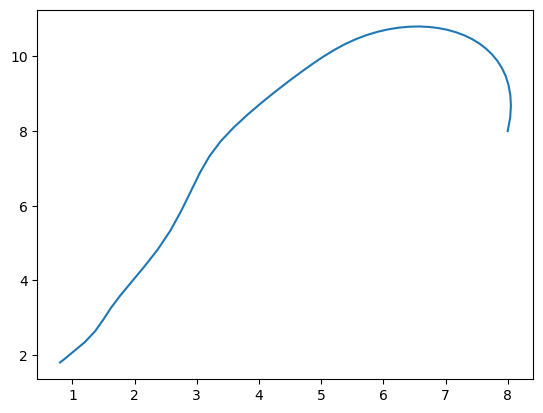

In [4]:
from math import dist
from scipy.spatial import Delaunay
import numpy as np
import itertools

# Function to check if a point lies inside a triangle using barycentric coordinates
def is_point_in_triangle(triangle, point):
    """
    Check if a point (x, y) lies within a triangle defined by three vertices.
    
    Parameters:
    - triangle: A list of three points [(x1, y1), (x2, y2), (x3, y3)] defining the triangle.
    - point: A tuple (x, y) representing the point to check.
    
    Returns:
    - True if the point lies within the triangle, False otherwise.
    """
    (x1, y1), (x2, y2), (x3, y3) = triangle
    x, y = point
    
    # Calculate the denominator for barycentric coordinates (determinant method)
    denominator = ((y2 - y3) * (x1 - x3) + (x3 - x2) * (y1 - y3))
    
    # If denominator is zero, the triangle is degenerate (collinear points)
    if denominator == 0:
        return False

    # Calculate barycentric coordinates (u, v, w)
    u = ((y2 - y3) * (x - x3) + (x3 - x2) * (y - y3)) / denominator
    v = ((y3 - y1) * (x - x3) + (x1 - x3) * (y - y3)) / denominator
    w = 1 - u - v
    
    # Check if the point is inside the triangle (all coordinates between 0 and 1)
    return (u >= 0) and (v >= 0) and (w >= 0) and (u + v <= 1)

# Function to calculate Euclidean distance between two points
def distance(p1, p2):
    """
    Calculate the Euclidean distance between two points p1 and p2.
    
    Parameters:
    - p1: Tuple (x1, y1) representing the first point.
    - p2: Tuple (x2, y2) representing the second point.
    
    Returns:
    - The Euclidean distance between p1 and p2.
    """
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

# Function to find the 3 closest paths that form a triangle containing the start point
def find_3_closest_paths(paths, start_point):
    """
    Find the three closest paths whose starting points form a triangle that contains the start point.
    
    Parameters:
    - paths: A list of paths, where each path is a list of points.
    - start_point: A tuple (x, y) representing the start point.
    
    Returns:
    - A list of 3 paths that form the triangle containing the start point.
    """
    d_min = np.inf  # Initialize the minimum distance as infinity
    closest_paths = []  # To store the closest 3 paths forming the triangle
    
    # Iterate through all combinations of 3 different paths
    for path1, path2, path3 in itertools.product(paths, paths, paths):
        # Ensure all paths are distinct
        if path1 == path2 or path2 == path3 or path1 == path3:
            continue
        
        # Create a triangle from the first points of the 3 paths
        triangle = [path1[0], path2[0], path3[0]]
        
        # Check if the start_point lies inside the triangle
        if is_point_in_triangle(triangle, start_point):
            # Calculate the maximum distance from start_point to each triangle vertex
            max_distance = np.max([distance(path1[0], start_point), distance(path2[0], start_point), distance(path3[0], start_point)])
            
            # Update the closest paths if a smaller max distance is found
            if max_distance < d_min:
                d_min = max_distance
                closest_paths = [path1, path2, path3]

    return closest_paths

# Function to compute the trajectory using the 3 closest paths
def find_trajectory(paths_triplet, start_point):
    """
    Generate a trajectory based on the 3 closest paths and the start point.
    
    Parameters:
    - paths_triplet: A list of 3 paths whose starting points form a triangle containing the start point.
    - start_point: A tuple (x, y) representing the starting point of the trajectory.
    
    Returns:
    - A list of points representing the trajectory.
    """
    trajectory = [start_point]  # Initialize the trajectory with the start point
    
    # Loop through each subsequent index in the paths (starting from 1, assuming all paths are of equal length)
    for i in range(1, len(paths_triplet[0])):
        # Compute inverse distance weights between the current point in the trajectory and the points in the paths
        weights = [1 / distance(trajectory[i - 1], paths_triplet[j][i]) for j in range(3)]
        weights_sum = sum(weights)  # Sum of the weights
        
        # Normalize the weights
        weights = [w / weights_sum for w in weights]
        
        # Compute the weighted average of the next point in the trajectory
        next_point_x = sum([weights[j] * paths_triplet[j][i][0] for j in range(3)])
        next_point_y = sum([weights[j] * paths_triplet[j][i][1] for j in range(3)])
        
        # Add the new point to the trajectory
        trajectory.append((next_point_x, next_point_y))
    
    return trajectory

# Example usage:
initial_point = (0.8, 1.8)  # Define the initial point

if initial_point[0] > initial_point[1]:
    paths_to_take = paths_below
else:
    paths_to_take = paths_above
# Assuming paths_above is defined somewhere else as a list of paths
trajectory = find_trajectory(find_3_closest_paths(paths_to_take, initial_point), initial_point)

# Plot the resulting trajectory
import matplotlib.pyplot as plt
plt.plot([x[0] for x in trajectory], [x[1] for x in trajectory])
plt.show()